In [270]:
# Dairy dataset
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import QuantileTransformer
import statsmodels.api as sm
from sklearn.decomposition import PCA



from warnings import filterwarnings 
filterwarnings('ignore')




df = pd.read_excel('./dataset_9/dairy_nutrition_9.xlsx')

*<h3>Functions needed to carry out PCA and plot the graphs</h3>*

In [271]:
def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    #PCA eigenvalues
    ev = pca.explained_variance_.reshape(len(pca.components_), 1)
    eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
    eigenvalues.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([eigenvalues, variance_ratios, components], axis = 1)


In [272]:
# Plots score plot with data labels
# Pass original data, un-centred scores and returns of PCA to this function. Optional width, height and margin.
# This function returns the axes of the score plot

def scoreplot_label(data, scores, pca, width=5, height=5, margin=0.5):
    plt.figure(figsize=(width, height))
    ax = sns.scatterplot(x="PC1", y="PC2", data = scores, hue=data['Type'])
    
    # Print text
    # text_pos = 0.2
    
    # for i, v in enumerate(np.array(scores)):
    #     # ax.arrow(0, 0, v[0], v[1], head_width=0.1, head_length=0.1, linewidth=2, color='red')
    #     ax.text(v[0], v[1]+text_pos, data.iloc[i,0], color='black', ha='center', va='center', fontsize=20)
    
    
    #Set limits for figure
    x_min = min(scores['PC1'].min(),0)-margin
    x_max = max(scores['PC1'].max(),0)+margin
    y_min = min(scores['PC2'].min(),0)-margin
    y_max = max(scores['PC2'].max(),0)+margin
  
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title("Score plot", fontsize=14)
    plt.plot([x_min, x_max], [0, 0], color='k', linestyle='--', linewidth=1)
    plt.plot([0, 0], [y_min, y_max], color='k', linestyle='--', linewidth=1)
    return ax

In [273]:
# This function plots the loading plot.
# Pass original data dataframe and returns of PCA to this function. Optional width, height and margin
# This function returns the axes of the loading plot

def loadingplot(data, pca, width=5, height=5, margin=0.5):

    fig, ax = plt.subplots(figsize = (width,height))

    #Set limits for figure
    x_min = min(pca.components_[0,:].min(),0)-margin
    x_max = max(pca.components_[0,:].max(),0)+margin
    y_min = min(pca.components_[1,:].min(),0)-margin
    y_max = max(pca.components_[1,:].max(),0)+margin

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    #Scaling factor for text position
    text_pos = 0.2

    for i, v in enumerate(pca.components_.T):
        ax.arrow(0, 0, v[0], v[1], head_width=0.1, head_length=0.1, linewidth=2, color='red')
        ax.text(v[0], v[1]+text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=12)

    plt.plot([x_min, x_max], [0, 0], color='k', linestyle='--', linewidth=1)
    plt.plot([0, 0], [y_min, y_max], color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("PC1", fontsize=14)
    ax.set_ylabel("PC2", fontsize=14)
    ax.set_title("Loading plot", fontsize = 14)
    
    return ax

---

In [274]:
df.head(15)

,Type,Description,Protein_g,Fat_g,Carb_g,Sugar_g,VitA_mcg,VitB6_mg,VitB12_mcg,Calcium_mg
0,Cheese,"Cheese food, cold pack, American",19.66,24.46,8.32,0.00,0,0.141,1.28,497
1,Cream,"Cream, whipped, cream topping, pressurized",3.20,22.22,12.49,8.00,188,0.041,0.29,101
2,Ice cream,"Fat free ice cream, no sugar added, flavors ot...",4.41,0.00,27.94,8.82,133,0.029,0.52,147
3,Milk,"Milk, whole, 3.25% milkfat, with added vitamin D",3.15,3.25,4.80,5.05,46,0.036,0.45,113
4,Milk,"Milk, whole, 3.25% milkfat, without added vita...",3.15,3.27,4.78,5.05,46,0.036,0.45,113
5,Yogurt,"Yogurt, chocolate, nonfat milk",3.53,0.00,23.53,14.97,0,0.047,0.50,88
6,Yogurt,"Yogurt, Greek, non fat, vanilla, CHOBANI",9.07,0.22,8.09,7.61,0,0.053,0.70,106
7,Milk,"Milk, chocolate, fluid, commercial, reduced fa...",2.99,1.90,12.13,9.55,64,0.024,0.33,109
8,Cream,"Cream, sour, cultured",2.07,19.73,2.88,2.88,176,0.057,0.28,110
9,Yogurt,"Yogurt, Greek, plain, nonfat",10.19,0.39,3.60,3.24,1,0.063,0.75,110


In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         172 non-null    object 
 1   Description  172 non-null    object 
 2   Protein_g    172 non-null    float64
 3   Fat_g        172 non-null    float64
 4   Carb_g       172 non-null    float64
 5   Sugar_g      172 non-null    float64
 6   VitA_mcg     172 non-null    int64  
 7   VitB6_mg     172 non-null    float64
 8   VitB12_mcg   172 non-null    float64
 9   Calcium_mg   172 non-null    int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 13.6+ KB


---

***<h3>Univariate Analysis</h3>***

- We check the assumptions and limitiations of the PCA to see if our data is eligible for PCA
- to check we will plot some of the more important columns to see if they match the assumptions of PCA  

***<h5>the assumptions and limitations of PCA are as follows:</h5>***

- The variables should be linearly related and have a linear correlation

- the principal components are orthogonal 

- If variables are normally distributed, then PCA will work better

- correlation coefficient tends to be less reliable when estimated from small samples therefore, it is important that sample size be large enough that correlations are reliably estimated.

In [276]:
# Columns to test are Fat_g, protein_g, sugar_g,calcium_mg, VitB6_mg

column = 'Fat_g'

fig = px.histogram(df, x= column, nbins=30)

fig.update_layout(
    title="Distribution of " + column,
    xaxis_title=column,
    yaxis_title="Count"
)

In [277]:
column = 'Protein_g'

fig = px.histogram(df, x= column, nbins=30)

fig.update_layout(
    title="Distribution of " + column,
    xaxis_title=column,
    yaxis_title="Count"
)

In [278]:
column = 'Carb_g'

fig = px.histogram(df, x= column, nbins=30)

fig.update_layout(
    title="Distribution of " + column,
    xaxis_title=column,
    yaxis_title="Count"
)

In [279]:
# columns_to_transform = ['Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g', 'Calcium_mg', 'VitB6_mg', 'VitB12_mcg', 'VitA_mcg']

# # Apply logarithmic transformation to selected columns
# # df[columns_to_transform] = np.log(df[columns_to_transform])

# transformer = QuantileTransformer(output_distribution='normal')

# df[columns_to_transform] = transformer.fit_transform(df[columns_to_transform])


# df

# instead of normalizing it we can just standardize the data

>Just to check if the principal componets are orthogonal

In [280]:
# columns_to_transform = ['Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g', 'Calcium_mg', 'VitB6_mg', 'VitB12_mcg', 'VitA_mcg']

# pca = PCA()
# principal_components = pca.fit_transform(df[columns_to_transform])

# # Calculate correlation matrix
# correlation_matrix = np.corrcoef(principal_components.T)

# # Check for orthogonality
# is_orthogonal = np.allclose(correlation_matrix, np.eye(correlation_matrix.shape[0]))
# print("Are the principal components orthogonal?", is_orthogonal)


---

**<h1>`Question 1 (A) and 1 (B)`</h1>**

In [281]:
df = pd.read_excel('./dataset_9/dairy_nutrition_9.xlsx')
df1 = df.drop(['Type', 'Description'], axis=1)
df1

,Protein_g,Fat_g,Carb_g,Sugar_g,VitA_mcg,VitB6_mg,VitB12_mcg,Calcium_mg
0,19.66,24.46,8.32,0.00,0,0.141,1.28,497
1,3.20,22.22,12.49,8.00,188,0.041,0.29,101
2,4.41,0.00,27.94,8.82,133,0.029,0.52,147
3,3.15,3.25,4.80,5.05,46,0.036,0.45,113
4,3.15,3.27,4.78,5.05,46,0.036,0.45,113
...,...,...,...,...,...,...,...,...
167,3.47,1.06,4.88,5.30,16,0.032,0.41,120
168,2.11,32.00,2.88,2.88,420,0.019,0.14,62
169,4.78,1.39,17.90,3.10,134,0.040,0.50,169
170,4.91,1.43,18.60,0.00,0,0.045,0.55,171


>drop the type and distribution columns so that we can feed the numerical values into PCA

**I Checked if the components are orthogonal or not**

In [282]:
pca = PCA()
principal_components = pca.fit_transform(df1)

# Calculate correlation matrix
correlation_matrix = np.corrcoef(principal_components.T)

# Check for orthogonality
is_orthogonal = np.allclose(correlation_matrix, np.eye(correlation_matrix.shape[0]))
print("Are the principal components orthogonal?", is_orthogonal)



Are the principal components orthogonal? True


In [283]:
data_standardized = (df1 - df1.mean())/df1.std()
data_standardized.head()

,Protein_g,Fat_g,Carb_g,Sugar_g,VitA_mcg,VitB6_mg,VitB12_mcg,Calcium_mg
0,0.728774,0.965428,-0.241193,-0.644294,-0.928364,0.839888,0.524361,0.403531
1,-0.881163,0.781915,0.065740,0.028659,0.525017,-0.381974,-0.650793,-0.766505
2,-0.762814,-1.038466,1.202937,0.097637,0.099826,-0.528598,-0.377777,-0.630591
3,-0.886054,-0.772208,-0.500283,-0.219492,-0.572750,-0.443067,-0.460869,-0.731049
4,-0.886054,-0.770570,-0.501755,-0.219492,-0.572750,-0.443067,-0.460869,-0.731049


>We standardized the data as from the analysis the data is skewed and all over the place

In [284]:
# implementing PCA using sklearn
from sklearn.decomposition import PCA

pca = PCA(n_components=8).fit(data_standardized)
#Note that pca.transform() returns scores based on centred data
pca_samples = pca.transform(data_standardized)


>Implement the PCA on the data

In [285]:
pca_results = pca_results(data_standardized, pca)
pca_results

,Eigenvalue,Explained Variance,Protein_g,Fat_g,Carb_g,Sugar_g,VitA_mcg,VitB6_mg,VitB12_mcg,Calcium_mg
PC 1,3.7340,0.4667,0.4731,0.2974,0.0517,0.0786,0.3650,0.3601,0.4411,0.4706
PC 2,2.1422,0.2678,-0.1048,-0.3213,0.6244,0.6061,-0.1748,0.2503,0.1712,-0.0778
PC 3,0.9068,0.1134,0.1550,-0.5709,-0.2856,-0.3362,-0.4771,0.3537,0.3014,0.1095
PC 4,0.4683,0.0585,-0.3454,-0.0460,-0.0831,-0.1744,0.4802,0.6552,-0.0375,-0.4242
PC 5,0.3271,0.0409,0.0030,-0.6693,-0.0554,0.0376,0.6109,-0.3749,0.0646,0.1724
PC 6,0.1948,0.0243,-0.1971,0.1395,0.2573,-0.3394,0.0107,-0.3239,0.7438,-0.3194
PC 7,0.1478,0.0185,0.3735,-0.1012,0.6407,-0.5562,0.0527,0.0434,-0.3531,-0.0321
PC 8,0.0790,0.0099,-0.6660,0.0518,0.1980,-0.2387,-0.0442,0.0774,-0.0419,0.6692


>As we can see from PCA, Since i will be using Kaisers rule i will be discard components that has a eigenvalue of less than 1 leaving us with only PC1 and PC2

<Figure size 640x480 with 0 Axes>

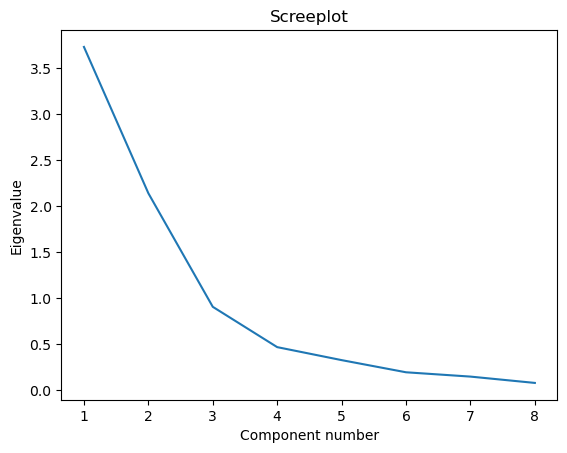

In [286]:
#Scree plot
import matplotlib.ticker as ticker
plt.clf()
fig1, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set(xlabel = 'Component number', ylabel = 'Eigenvalue', title = 'Screeplot')
plt.show()

>From the scree plot the elbow is at 4 components however based on kaisers rule we only need PC1 and PC2 hence i decided to discard the other components and keep those 2

In [287]:
#Extract only the two PCs
pca2 = PCA(n_components=2).fit(data_standardized)
scores2 = pca2.transform(data_standardized)

>Extract 2 PCs

In [288]:
#Obtain scores from original data that are not centred

scores_notcentred = np.dot(data_standardized, pca2.components_.T)
scores_notcentred = pd.DataFrame(scores_notcentred, columns = ['PC1', 'PC2'])
scores_notcentred.head()

,PC1,PC2
0,0.953542,-0.496858
1,-0.772259,-0.339564
2,-1.217161,1.058514
3,-1.607844,-0.137269
4,-1.607433,-0.138715


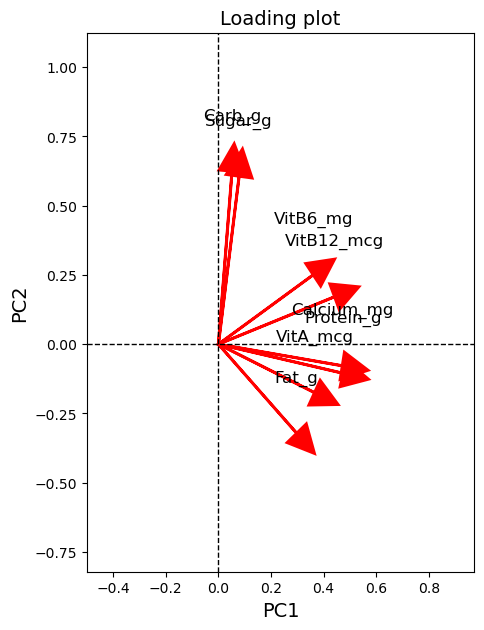

In [289]:
plt.clf
ax2 = loadingplot(data_standardized, pca, width=5, height=7)
plt.show()

**<h4>Short Summary</h4>**

> For PC1 we can see that vitamin B6, B12, A, calcium, Protein, Fat all have a strong positive contribution to PC1
> While Carbohydrates and Sugar tho positive contribution is a lot lesser compared to the other nutrients

> For PC2 we can see that Carbohydrates and Sugar contribute the positive to PC2, while vitamin B6 and B12 also contributed positively it was a lot lesser  
> compared to the other nutrients calcium, protein, vitamin A, and Fat contributed negatively to PC2 

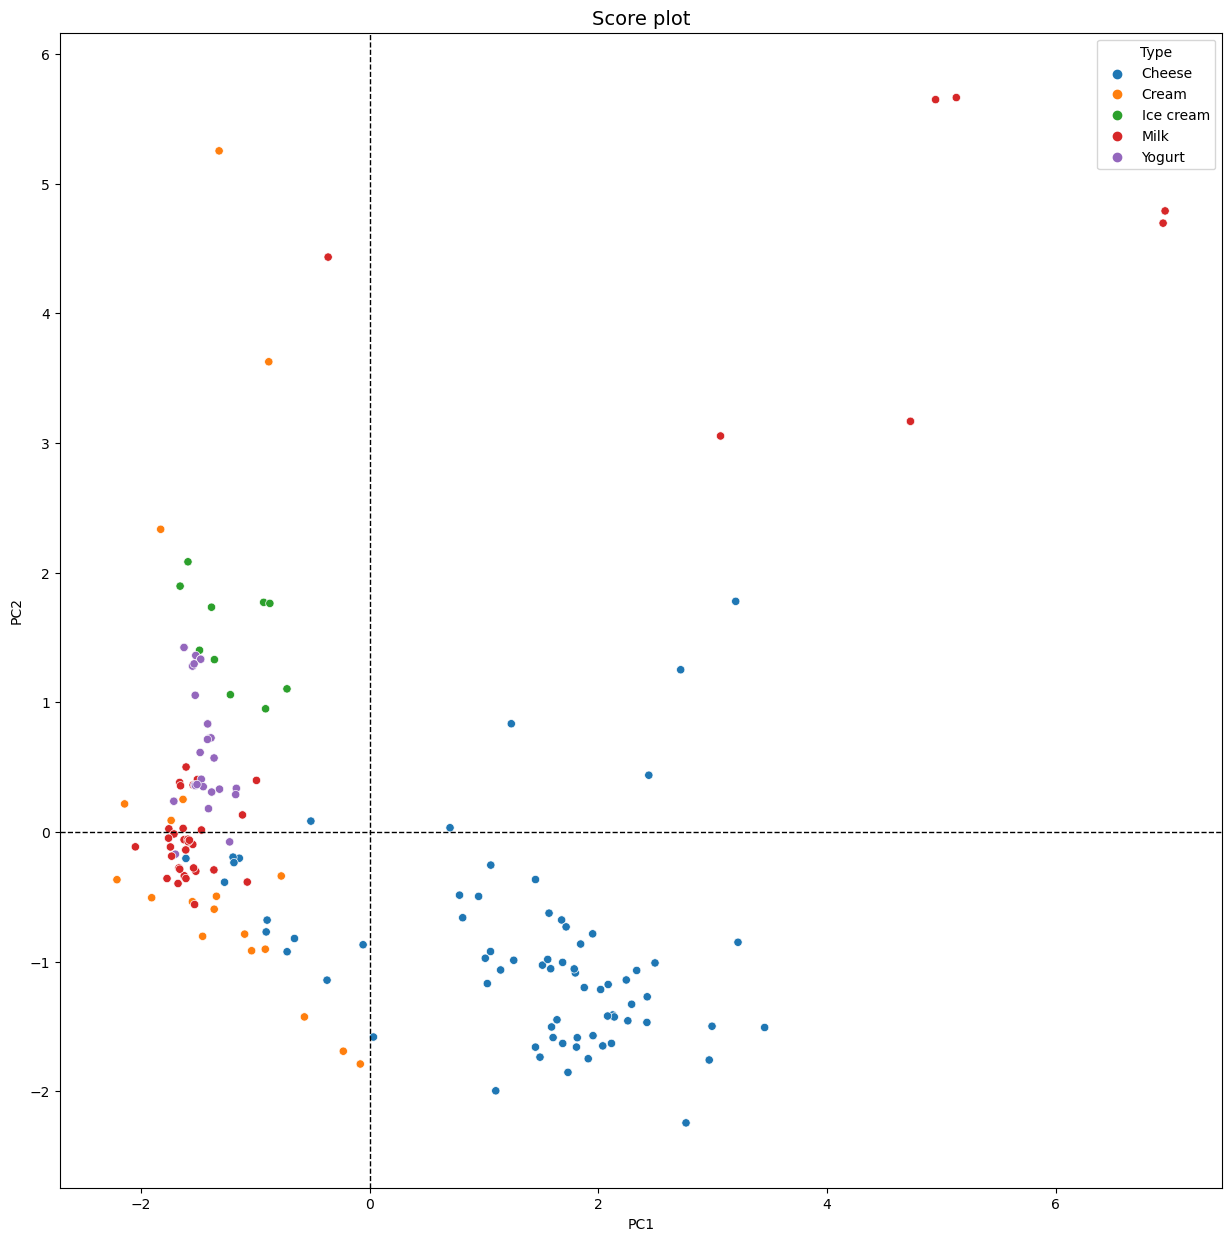

In [290]:
plt.clf

ax3 = scoreplot_label(df, scores_notcentred, pca, height =15, width = 15)
plt.show()

---

**<h1>`Question 1 (C)`</h1>**

*<h3>Steps i need to do</h3>*

Since when new points are introduced the PCA results will change i need to:

- Add the 2 new data points (rows) into the dataset

- Evaluate a new PCA result and determine how many components to keep

- plot all the necessary graphs and infer from there 

In [296]:

def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    #PCA eigenvalues
    ev = pca.explained_variance_.reshape(len(pca.components_), 1)
    eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
    eigenvalues.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([eigenvalues, variance_ratios, components], axis = 1)

In [291]:
df

,Type,Description,Protein_g,Fat_g,Carb_g,Sugar_g,VitA_mcg,VitB6_mg,VitB12_mcg,Calcium_mg
0,Cheese,"Cheese food, cold pack, American",19.66,24.46,8.32,0.00,0,0.141,1.28,497
1,Cream,"Cream, whipped, cream topping, pressurized",3.20,22.22,12.49,8.00,188,0.041,0.29,101
2,Ice cream,"Fat free ice cream, no sugar added, flavors ot...",4.41,0.00,27.94,8.82,133,0.029,0.52,147
3,Milk,"Milk, whole, 3.25% milkfat, with added vitamin D",3.15,3.25,4.80,5.05,46,0.036,0.45,113
4,Milk,"Milk, whole, 3.25% milkfat, without added vita...",3.15,3.27,4.78,5.05,46,0.036,0.45,113
...,...,...,...,...,...,...,...,...,...,...
167,Milk,"Milk, fluid, 1% fat, without added vitamin A a...",3.47,1.06,4.88,5.30,16,0.032,0.41,120
168,Cream,"Cream, fluid, heavy whipping",2.11,32.00,2.88,2.88,420,0.019,0.14,62
169,Yogurt,"Yogurt, fruit, lowfat, with low calorie sweete...",4.78,1.39,17.90,3.10,134,0.040,0.50,169
170,Yogurt,"Yogurt, fruit, low fat, 11 grams protein per 8...",4.91,1.43,18.60,0.00,0,0.045,0.55,171


In [292]:
new_row = [pd.Series({'Type': 'Product 1', 'Description': 'Product 1' , 'Protein_g': 22.17 , 'Fat_g': 23.5, 'Carb_g': 2.22, 'Sugar_g': 1.01, 'VitA_mcg': 181, 'VitB6_mg': 0.034, 'VitB12_mcg': 2.28, 'Calcium_mg': 505}, name=len(df1)),
          pd.Series({'Type': 'Product 2', 'Description': 'Product 2' ,'Protein_g': 4.32 , 'Fat_g': 1.42, 'Carb_g': 23.0, 'Sugar_g': 14.58, 'VitA_mcg': 13, 'VitB6_mg': 0.047, 'VitB12_mcg': 0.53, 'Calcium_mg': 114}, name=len(df1)+1) ]

new_df = df.append(new_row)
df2 = new_df.drop(['Type', 'Description'], axis=1)
display(new_df.tail(2))
display(df2.tail(2))

,Type,Description,Protein_g,Fat_g,Carb_g,Sugar_g,VitA_mcg,VitB6_mg,VitB12_mcg,Calcium_mg
172,Product 1,Product 1,22.17,23.50,2.22,1.01,181,0.034,2.28,505
173,Product 2,Product 2,4.32,1.42,23.00,14.58,13,0.047,0.53,114


,Protein_g,Fat_g,Carb_g,Sugar_g,VitA_mcg,VitB6_mg,VitB12_mcg,Calcium_mg
172,22.17,23.50,2.22,1.01,181,0.034,2.28,505
173,4.32,1.42,23.00,14.58,13,0.047,0.53,114


> ##### Add 2 new rows to the data frame with the new values of the 2 product, i added it to the un reduced data so that it could be labeled later in the score plot

In [293]:
data_standardized = (df2 - df2.mean())/df2.std()
data_standardized

,Protein_g,Fat_g,Carb_g,Sugar_g,VitA_mcg,VitB6_mg,VitB12_mcg,Calcium_mg
0,0.728570,0.966647,-0.242626,-0.646951,-0.929255,0.848503,0.515064,0.406778
1,-0.883492,0.782941,0.065037,0.028640,0.528742,-0.379370,-0.656532,-0.767638
2,-0.764987,-1.039354,1.204936,0.097888,0.102201,-0.526715,-0.384343,-0.631216
3,-0.888389,-0.772817,-0.502331,-0.220484,-0.572511,-0.440764,-0.467183,-0.732050
4,-0.888389,-0.771177,-0.503807,-0.220484,-0.572511,-0.440764,-0.467183,-0.732050
...,...,...,...,...,...,...,...,...
169,-0.728750,-0.925358,0.464186,-0.385159,0.109956,-0.391649,-0.408011,-0.565971
170,-0.716018,-0.922078,0.515832,-0.646951,-0.929255,-0.330256,-0.348840,-0.560039
171,-0.810039,-0.947501,0.528374,0.938154,-0.828436,-0.403928,-0.490851,-0.657907
172,0.974395,0.887916,-0.692683,-0.561657,0.474455,-0.465322,1.698494,0.430503


In [294]:
pca = PCA(n_components=8).fit(data_standardized)
#Note that pca.transform() returns scores based on centred data
pca_samples = pca.transform(data_standardized)

In [297]:
pca_results = pca_results(data_standardized, pca)
pca_results

,Eigenvalue,Explained Variance,Protein_g,Fat_g,Carb_g,Sugar_g,VitA_mcg,VitB6_mg,VitB12_mcg,Calcium_mg
PC 1,3.7312,0.4664,0.4743,0.3019,0.0428,0.0708,0.3674,0.3561,0.4394,0.4713
PC 2,2.1462,0.2683,-0.0985,-0.3164,0.6255,0.6079,-0.1686,0.2578,0.1720,-0.0701
PC 3,0.9004,0.1126,0.1549,-0.5699,-0.2840,-0.3354,-0.4787,0.3551,0.3016,0.1090
PC 4,0.4684,0.0585,-0.3422,-0.0446,-0.0841,-0.1740,0.4776,0.6619,-0.0513,-0.4179
PC 5,0.3249,0.0406,0.0005,-0.6704,-0.0554,0.0357,0.6119,-0.3723,0.0691,0.1685
PC 6,0.2014,0.0252,-0.2037,0.1437,0.2220,-0.3047,0.0128,-0.3144,0.7609,-0.3432
PC 7,0.1479,0.0185,0.3539,-0.0926,0.6556,-0.5764,0.0515,0.0250,-0.3158,-0.0344
PC 8,0.0796,0.0099,-0.6764,0.0575,0.1925,-0.2374,-0.0455,0.0662,-0.0162,0.6626


>The PCA results we obtained after adding the 2 new records slightly changed compared to the one in question 1 A

<Figure size 640x480 with 0 Axes>

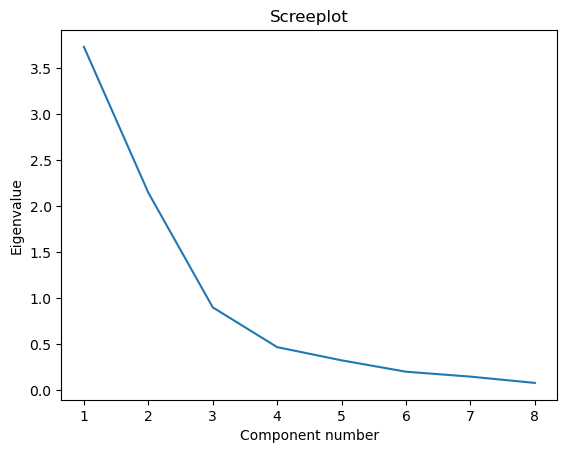

In [298]:
import matplotlib.ticker as ticker
plt.clf()
fig1, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set(xlabel = 'Component number', ylabel = 'Eigenvalue', title = 'Screeplot')
plt.show()

> similarly to question 1 the screeplot suggests to keep 4 components however based on kaisers rule we only need PC1 and PC2 hence i decided to discard the other components and keep those 2

In [299]:
pca2 = PCA(n_components=2).fit(data_standardized)
scores2 = pca2.transform(data_standardized)

> Extract those 2 PCs

In [300]:
scores_notcentred = np.dot(data_standardized, pca2.components_.T)
scores_notcentred = pd.DataFrame(scores_notcentred, columns = ['PC1', 'PC2'])
scores_notcentred

,PC1,PC2
0,0.960118,-0.487103
1,-0.769053,-0.348686
2,-1.234587,1.042488
3,-1.609419,-0.162457
4,-1.608987,-0.163899
...,...,...
169,-1.177558,0.270712
170,-1.517950,0.342376
171,-1.555255,1.277537
172,1.618688,-1.089466


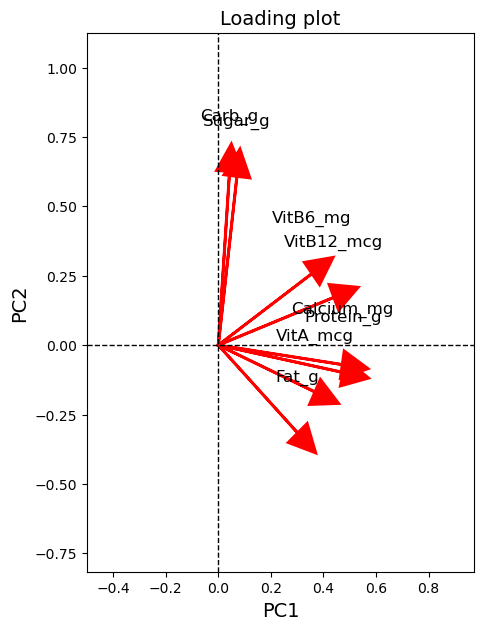

In [301]:
plt.clf
ax2 = loadingplot(data_standardized, pca, width=5, height=7)
plt.show()

**<h4>Short Summary</h4>**
**`Similarly to loading plot in question 1A`**

> For PC1 we can see that vitamin B6, B12, A, calcium, Protein, Fat all have a strong positive contribution to PC1
> While Carbohydrates and Sugar tho positive contribution is a lot lesser compared to the other nutrients

> For PC2 we can see that Carbohydrates and Sugar contribute the positive to PC2, while vitamin B6 and B12 also contributed positively it was a lot lesser  
> compared to the other nutrients calcium, protein, vitamin A, and Fat contributed negatively to PC2 

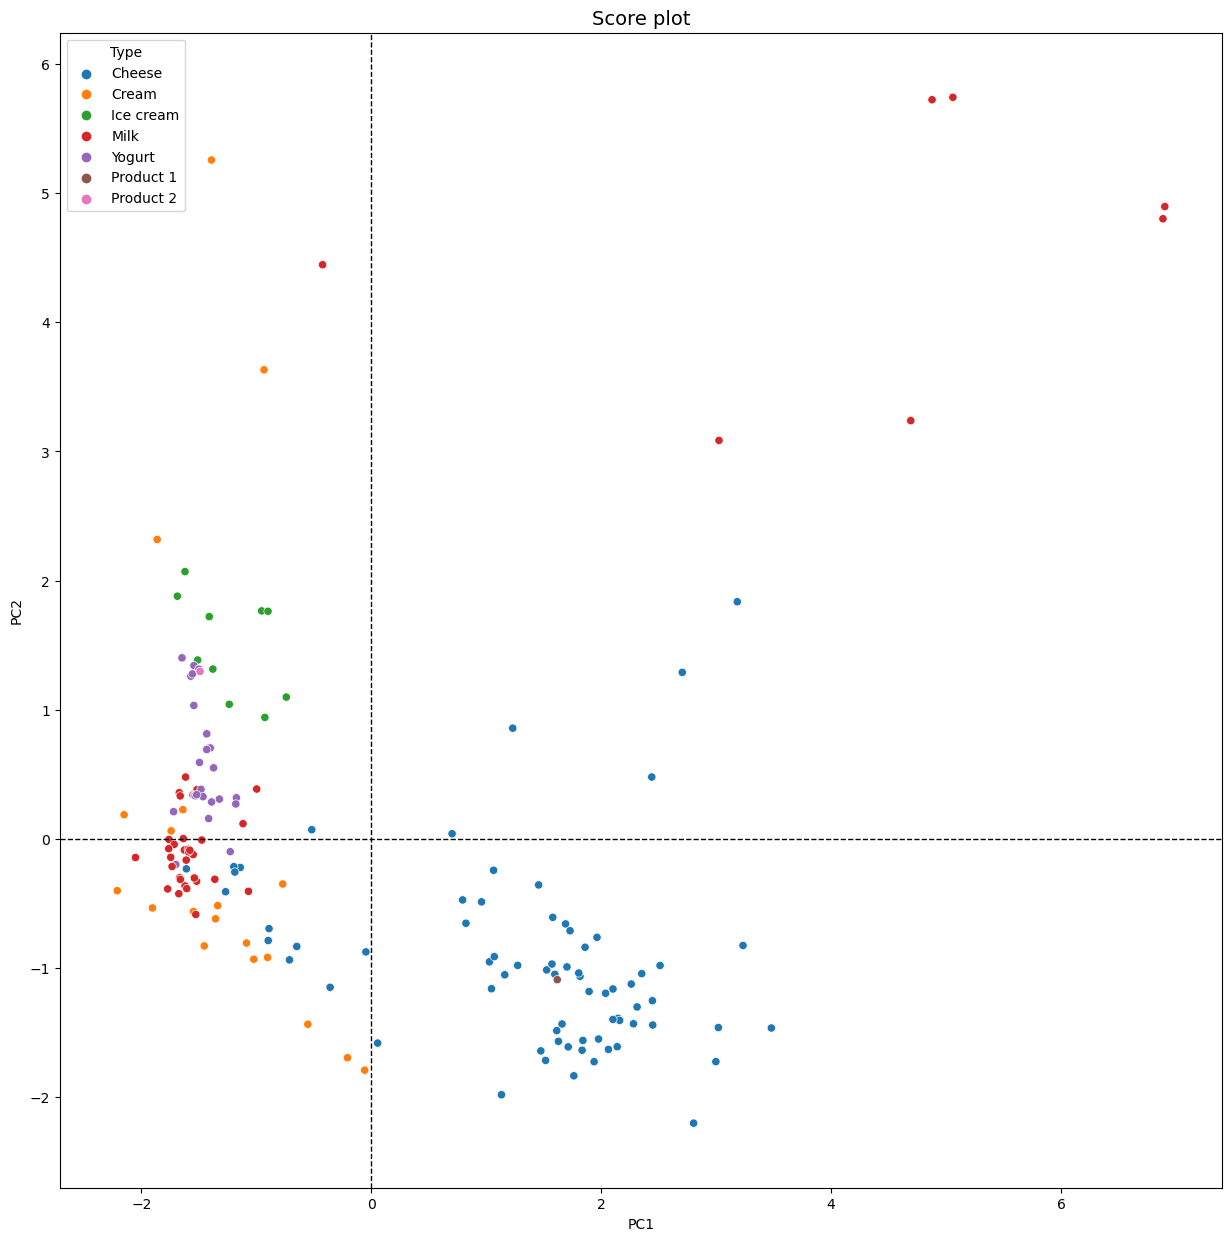

In [302]:
plt.clf

ax3 = scoreplot_label(new_df, scores_notcentred, pca, height =15, width = 15)
plt.show()

>We can see where the new points are located in the score plot and see which cluster they are closest to and belong to

- For product 1 it is closest to all the milk product hence likely to be a milk product

- For product 2 it is close to both yogurt and ice cream products however i see more yogurt data points around it hence i will classify it as a yogurt product

---

**<h3>`Question 1 (D)`</h3>**

Expected = subbing in the standardized values into PCA created in question 1 (A)

Actual = subbing in the standardized values into PCA created in question 1 (C)

<!--  -->

**`Product 1 (Expected)`**


In [303]:
x1 = ((0.4731)*(0.974395)) + (0.2974*(0.887916)) + (0.0517*(-0.692683))  + (0.0786*(-0.561657)) + (0.3650*(0.474455)) + (0.3601*(-0.465322)) + (0.4411*(1.698494)) + (0.4706*(0.430503))
x1 

1.6025085795999998

In [304]:
y1 = ((-0.0985)*(0.974395)) + (-0.3164*(0.887916)) + (0.6255*(-0.692683))  + (0.6079*(-0.561657)) + (-0.1686*(0.474455)) + (0.2578*(-0.465322)) + (0.1720*(1.698494)) + (-0.0701*(0.430503))
y1

-1.0896094536

**`Product 2 (Expected)`**

In [305]:
x2 = ((0.4731)*(-0.773801)) + (0.2974*(-0.922898)) + (0.0517*(0.840463))  + (0.0786*(0.584313)) + (0.3650*(-0.828436)) + (0.3601*(-0.305698)) + (0.4411*(-0.372508)) + (0.4706*(-0.729084))
x2

-1.4710573784

In [306]:
y2 = ((-0.0985)*(-0.773801)) + (-0.3164 *(-0.922898)) + (0.6255*(0.840463))  + (0.6079*(0.584313)) + (-0.1686*(-0.828436)) + (0.2578*(-0.305698)) + (0.1720*(-0.372508)) + (-0.0701*(-0.729084))
y2

1.2970405824999998

>Add these points into the data

In [307]:
# scores_notcentred

# record1 = pd.DataFrame({'PC1': [x1], 'PC2': [y1]})
# record2 = pd.DataFrame({'PC1': [x2], 'PC2': [y2]})

# df = sc.append(new_data, ignore_index=True)

new_row = [pd.Series({'PC1': x1, 'PC2': y1 }, name=len(df1)),
          pd.Series({'PC1': x2, 'PC2': y2 }, name=len(df1)+1) ]

scores_notcentred2 = scores_notcentred.append(new_row)

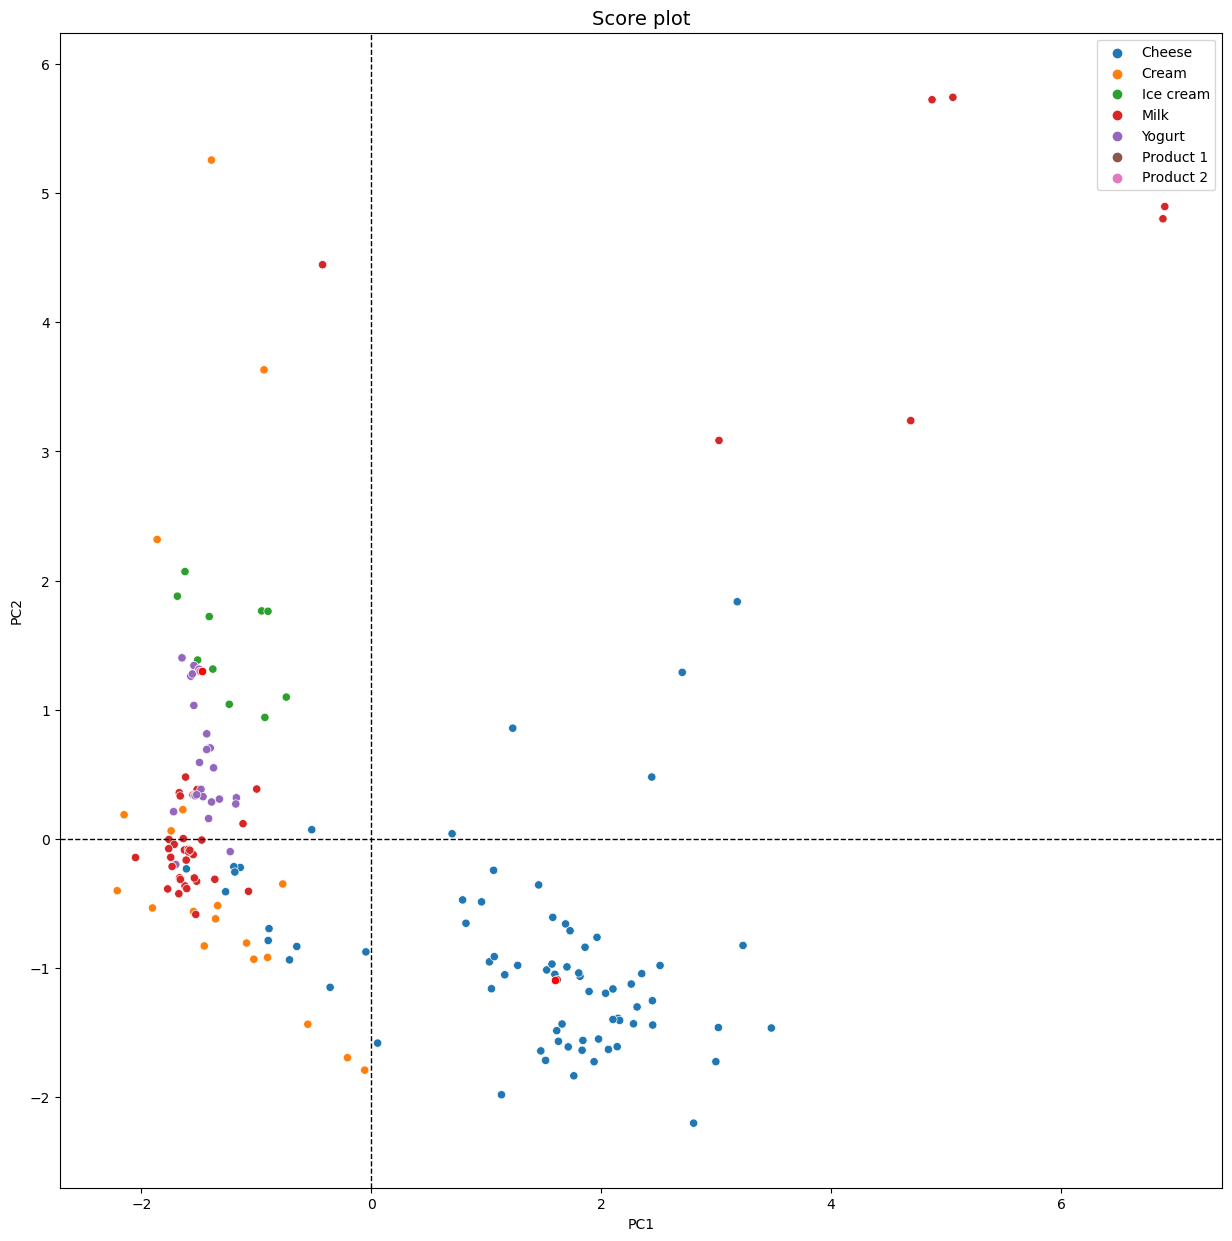

In [308]:
plt.clf

ax3 = scoreplot_label(new_df, scores_notcentred, pca, height =15, width = 15)

extra_points = pd.DataFrame({'PC1': [x1, x2], 'PC2': [y1, y2]})
sns.scatterplot(x="PC1", y="PC2", data=extra_points, color='red')

plt.show()

>The points are so close together that it covers up each other which matches up to my expectation as i know there would be a slight change but nothing too drastic

---

**<h2>`For question 2 (B)`</h2>**

<h3>Usefullness for classification/clustering</h3>

I Feel like it is extremely useful due to a few points:

- Clear clusters can be seen and inferred from the score plot

- Successful classification of the 2 new products

- Reduction of the number of dimensions

---

Spaghetti Recipe (click to read more)

<!-- ## Ingredients:
- 8 ounces (225g) spaghetti
- 1 tablespoon olive oil
- 3 cloves garlic, minced
- 1 small onion, finely chopped
- 1 can (14 ounces/400g) crushed tomatoes
- 1 teaspoon dried basil
- 1 teaspoon dried oregano
- Salt and pepper to taste
- Fresh basil leaves, for garnish
- Grated Parmesan cheese, for serving

## Instructions:
1. Cook the spaghetti according to the package instructions until al dente. Drain and set aside.

2. In a large skillet, heat olive oil over medium heat. Add garlic and onion, and sauté until translucent and fragrant.

3. Add crushed tomatoes, dried basil, dried oregano, salt, and pepper to the skillet. Stir well to combine. Simmer the sauce for about 15 minutes to allow the flavors to meld together.

4. Add the cooked spaghetti to the skillet and toss it in the sauce until well coated.

5. Serve the spaghetti hot, garnished with fresh basil leaves and grated Parmesan cheese.

Enjoy your delicious spaghetti meal! -->